# "First Love" dataset

In [12]:
#%pip install datasets

import datasets
from pathlib import Path


dataset = datasets.load_dataset("llamore/first_love", split="train")
data_path = Path("./data/first_love")
pdfs_path = data_path / "pdfs"

In [7]:
# Export PDFs
pdfs_path.mkdir(parents=True, exist_ok=True)

for pdf in dataset["pdf"]:
    pdf_path = data_path / "pdfs" / pdf["path"]
    pdf_path.write_bytes(pdf["bytes"])

## Inference with GROBID flavor

In [6]:
import httpx


def extract_references_with_grobid_flavor(pdf: Path, output: Path) -> Path | None:
    files = {
        "input": open(pdf, "rb"),
        "flavor": (None, "article/dh-law-footnotes"),
    }
    response = httpx.post("https://lfoppiano-grobid-dev-footnotes.hf.space/api/processFulltextDocument", files=files)

    if response.status_code != 200:
        print(f"Error extracting references from {pdf}: {response.status_code} {response.text}")
        return

    output.write_bytes(response.content)

    return output

In [ ]:
grobid_flavor_path = data_path / "grobid-flavor" 
grobid_flavor_path.mkdir(parents=True, exist_ok=True)

for pdf in pdfs_path.glob("*.pdf"):
    print(f"Processing {pdf} ...")

    output_path = grobid_flavor_path / f"{pdf.stem}.xml"
    if output_path.exists():
        print(f"Output file {output_path} already exists. Skipping.")
        continue

    extract_references_with_grobid_flavor(pdf, output_path)

## Inference with Llamore (gemini-2.5-pro)

In [8]:
import os
from llamore import GeminiExtractor


extractor = GeminiExtractor(model="gemini-2.5-pro", api_key=os.environ["GEMINI_API_KEY"])

In [ ]:
gemini_25pro_path = data_path / "gemini-2.5-pro" 
gemini_25pro_path.mkdir(parents=True, exist_ok=True)

for pdf in pdfs_path.glob("*.pdf"):
    print(f"Processing {pdf} ...")

    output_path = gemini_25pro_path / f"{pdf.stem}.xml"
    if output_path.exists():
        print(f"Output file {output_path} already exists. Skipping.")
        continue

    references = extractor(pdf=pdf)
    references.to_xml(output_path)

## Evaluate

In [ ]:
#%pip install pandas seaborn

In [ ]:
from llamore import References, F1
import pandas as pd


f1, f1s = F1(levenshtein_distance=0), []
output_paths = [data_path / "grobid-flavor", data_path / "gemini-2.5-pro"]

for output_path in output_paths:
    print(f"Evaluating references extracted in {output_path} ...")
    for row in dataset:
        output_file = output_path / f"{Path(row['pdf']['path']).stem}.xml"
        extracted_references = References.from_xml(output_file)
        gold_references = References.from_xml(xml_str=row["references"])

        macro_average = f1.compute_macro_average(extracted_references, gold_references, show_progress=False)
        f1s.append({"model": output_path.name, "metric": "macro_average", "f1": macro_average})

        micro_average = f1.compute_micro_average(extracted_references, gold_references, show_progress=False)
        for metric_name, metric in micro_average.items():
            metric_name = metric_name.replace("Reference.", "")
            f1s.append({"model": output_path.name, "metric": metric_name, "f1": metric["f1"]})

df = pd.DataFrame(f1s)


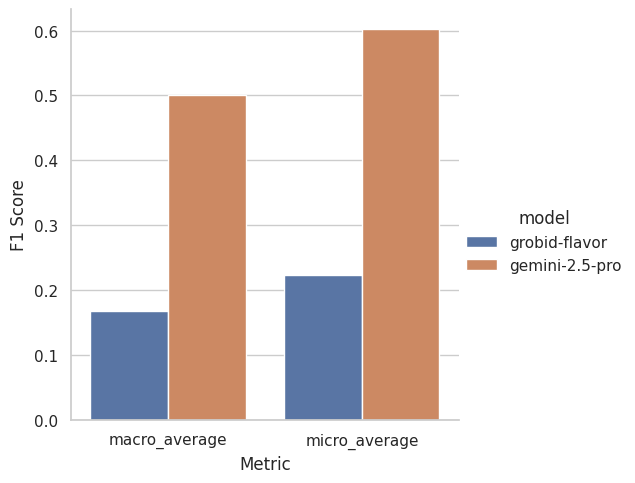

In [ ]:
import seaborn as sns
sns.set_theme(style="whitegrid")


model_order = ["grobid-flavor", "gemini-2.5-pro"] 
idx = df.metric.isin(["micro_average", "macro_average"])

rf = sns.catplot(data=df[idx], x="metric", y="f1", kind="bar", hue="model", hue_order=model_order, errorbar=None)

rf.set_axis_labels("Metric", "F1 Score")

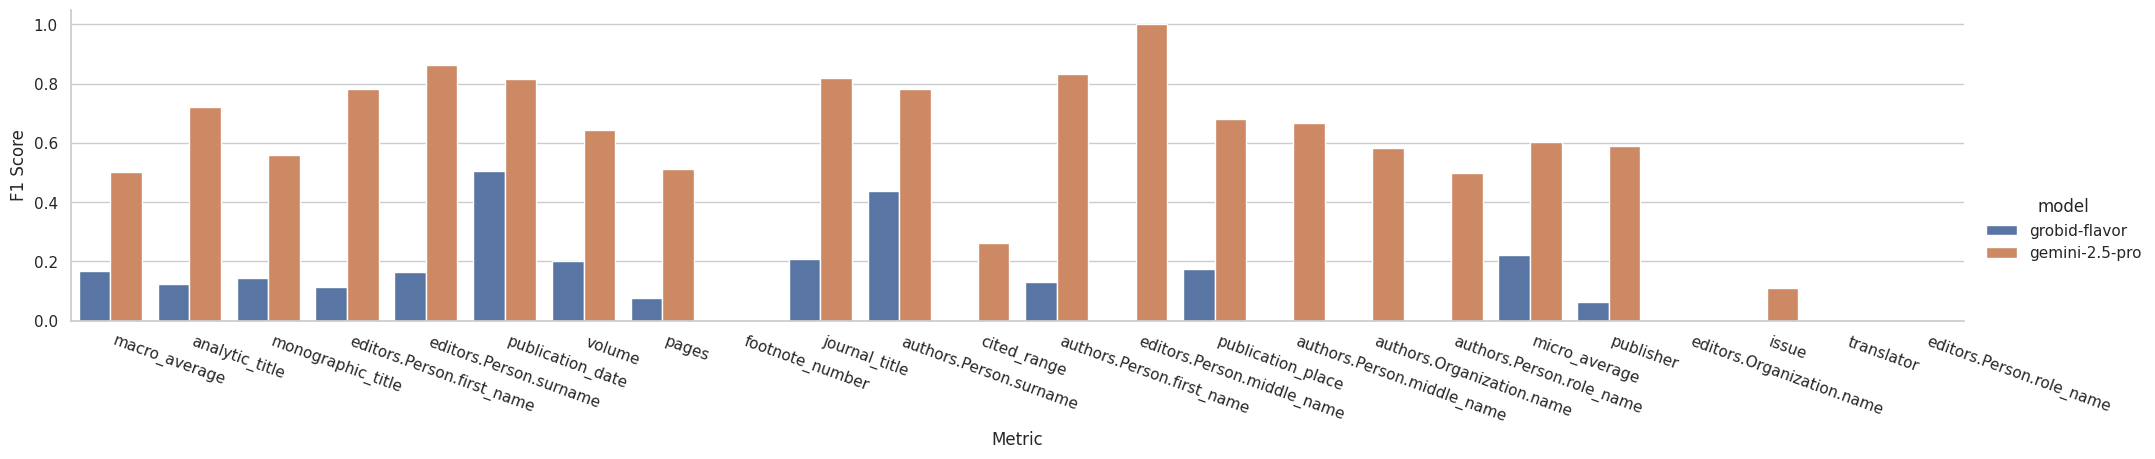

In [ ]:
rf = sns.catplot(data=df, x="metric", y="f1", kind="bar", hue="model", height=4, aspect=5, hue_order=model_order, errorbar=None)

rf.set_xticklabels(rotation=-20, ha='left')
rf.set_axis_labels("Metric", "F1 Score")